# Run Pre-processing RSP LUT for training/prediction purposes
this is the scheme flow to run pre-processing for either
training dataset or measurement dataset
this is based on preproc module
this version is with the correct scaling of pca/projections
this version has reading of dolp from NN input files (calculated with the u component)
also it has the platform choice to use altitude dependent/not LUT

steps:
======
1. reading LUT netcdf file
2. create PCA rotation (Qi,Ri,DoLP) for no_noise dataset
(this is running from VZA of -40 to 40 as defined in preproc)
3. project each RSP component (Qi,Ri,DoLP) by no_noise rotation
4. concatanate one/two variables (only Ri/Qi or Ri and DoLP or Qi and DoLP etc.)
4. add original output variables to dataframe when in training mode
5. concatanate all data frames into one dataframe that is used as input to run_NN routine

In [1]:
# import neccesary modules for this module
#-------------------------------------------
import pandas as pd
import numpy as np
import scipy as sio
import scipy.stats as stats
import netCDF4 as nc4

In [2]:
## read netcdf parameters from LUT or measurements files
## nc_file is full file path, 
## e.g. filepath = '..//..//py_data//oracles_NN//training//NNcld_20150911_20160102_20160420_nonoise.nc'
## varname is netcdf variable name string in file, e.g. "ref_i"
##--------------------------------------------------------------

def read_nc_file( nc_file, varname ):
    f = nc4.Dataset(nc_file)
    data = f.variables[varname]
    #f.close()
    return data;

In [3]:
## cat netcdf parameters from LUT or measurements files
## to create dataframe in pandas, 
## colname is column name to change from default
##-----------------------------------------------------

def create_df_from_nc( nc_data, colname ):
    df = pd.DataFrame([])
    # check data size and length 
    l = len(nc_data.shape)
    vza = np.arange(24,125)
    # if l=3 cat dataframe, if l=1 save var as df
    if   l==3:
        # wavelength dim is the 2nd element
        for i in range(nc_data.shape[1]):
                #df=df.append(pd.DataFrame(nc_data[:,i,:]))
                tmp = pd.DataFrame(np.transpose(nc_data[vza,i,:]))# only VZA -40 to 40
                # rename column name
                tmp.rename(columns=lambda x: colname + '_lambda_' + str(i+1) + '_VZA_',
                               inplace=True)
                df = pd.concat([df, tmp], axis=1)
                
    elif l==2:
            tmp = pd.DataFrame(np.transpose(nc_data[3,:])) # 3 is the VZA index (all rows suppose to be similar)
            df=df.append(pd.DataFrame(tmp))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    elif l==1:
            df=df.append(pd.DataFrame(nc_data[:]))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    return df;

In [4]:
# test read_nc_file for training
filepath = '..//..//py_data//oracles_NN//measurements//RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN.nc'
data = read_nc_file( nc_file=filepath, varname="ref_i" )
data.shape

(152, 7, 1219)

In [5]:
## cat netcdf parameters from LUT or measurements files
## to create dataframe in pandas, 
## colname is column name to change from default
## this tweak is for reduced wln range
##-----------------------------------------------------

def create_df_reduced_from_nc( nc_data, colname ):
    df = pd.DataFrame([])
    # check data size and length 
    l = len(nc_data.shape)
    vza = np.arange(24,125)
    wln_reduced = nc_data.shape[1] - 2
    print wln_reduced
    
    # if l=3 cat dataframe, if l=1 save var as df
    if   l==3:
        # run along wavelength dim
        for i in range(wln_reduced):
                #df=df.append(pd.DataFrame(nc_data[:,i,:]))
                tmp = pd.DataFrame(np.transpose(nc_data[vza,i,:]))# only VZA -40 to 40
                # rename column name
                tmp.rename(columns=lambda x: colname + '_lambda_' + str(i+1) + '_VZA_',
                               inplace=True)
                df = pd.concat([df, tmp], axis=1)
                
    elif l==2:
            tmp = pd.DataFrame(np.transpose(nc_data[3,:])) # 3 is the VZA index (all rows suppose to be similar)
            df=df.append(pd.DataFrame(tmp))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    elif l==1:
            df=df.append(pd.DataFrame(nc_data[:]))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    return df;

In [6]:
# test create_df_from_nc
ref_i = create_df_reduced_from_nc( data, colname="ref_i")
ref_i.head()
ref_i.shape

5


(1219, 505)

In [7]:
# test create_df_from_nc
ref_i = create_df_from_nc( data, colname="ref_i")
ref_i.head()
ref_i.shape

(1219, 707)

In [8]:
## perform PCA on a dataframe using eigen decomposition
## inputs are:
## data - data frame of ref_i, ref_q etc
## numPC - number of PC's to retain for this dataset
## the function returns:
## PC - principle component array 
## rot - rotation array (for number of selected PC's)
## proj - projected data set (data*rot)
##---------------------------------------------------

def run_pc( data_df, numPC ):
    
    # import moduls
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # extract values only from DF
    data = data_df.ix[:,:].values
    
    # standartize
    std_scale = StandardScaler().fit(data)
    data_std  = std_scale.fit_transform(data)
    
    #data_std = StandardScaler().fit_transform(data)# from run_pc
    
    # covariance matrix
    cov_mat_std = np.cov(data_std.T)
    
    # eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(cov_mat_std)
    
    # sort eigenvalue in decreasing order
    idx = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:,idx]
    # sort eigenvectors according to same index
    eig_vals = eig_vals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array)
    #eig_vecs = eig_vecs[:, :numPC]
    
    # print eig_vecs shape
    print "eig_vec"
    print eig_vecs.shape
    
    # calculate percent variance
    eig_sum = np.real(sum(eig_vals))
    #print "sum"
    #print eig_sum
    
    eig_rel = np.real(eig_vals/eig_sum)
    #print "relative importance"
    #print eig_rel
    
    #Cumulative Variance explains
    var1 = np.cumsum(np.round(eig_rel, decimals=4)*100)
    
    print 'cumulative variance'
    #print var1
    plt.plot(var1)

    #print('Eigenvectors \n%s' %eig_vecs)
    #print('\nEigenvalues \n%s' %eig_vals)
    
    print 'eigenvectors'
    print np.real(eig_vecs[0:5,0:5])
    print 'eigenvalues'
    print np.real(eig_vals[0:15])
    
    pc   = np.real(eig_vecs)
    rot  = pc[:,0:numPC]     # rot is the projected data
    proj = data_std.dot(rot) # Y=X*W (W is weight matrix)
    #proj_= np.dot(rot.T, data_std.T).T
    
    print "rot-all"
    print pc[0:5,0:2]
    print pc.shape
    
    print "proj"
    print proj[0:5,0:2]
    print proj.shape
    
    #print "proj_"
    #print proj_[0:5,0:2]
    #print proj_.shape
    
    return std_scale, pc, rot, proj

In [9]:
# test read_nc_file for training
#filepath = '..//..//py_data//oracles_NN/simulated_files//NNcld_20150911_20160102_20160420_nonoise.nc'
#data1 = read_nc_file( nc_file=filepath, varname="ref_q" )
#ref_q = create_df_from_nc( data1, colname="ref_q")
#data2 = read_nc_file( nc_file=filepath, varname="ref_i" )
#ref_i = create_df_from_nc( data2, colname="ref_i")
# test run_pc
#std_scale, pc, rot, proj = run_pc( ref_i, numPC=5 )
# rename
#ref_i.rename(columns=lambda x: x.replace("ref_i", 'ref_q'), inplace=True)

#dolp  = (ref_q / ref_i).abs()

#std_scale, pc, rot, proj = run_pc( ref_q, numPC=20 )
#std_scale, pc, rot, proj = run_pc( dolp, numPC=20 )

In [10]:
## perform PCA on a dataframe using PCA
## inputs are:
## data - data frame of ref_i, ref_q etc
## numPC - number of PC's to retain for this dataset
## the function returns:
## pca       - principle component class
## pca_std   - principle compoennt class for standartized data
## std_scale - scaling class
##-----------------------------------------------------------

def run_pca( data_df, numPC ):
    # import moduls
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import scale
    %matplotlib inline
    
    # extract values only from DF
    data = data_df.ix[:,:].values
    
    # std_scale data
    
    std_scale  = StandardScaler().fit(data)
    data_std   = std_scale.transform(data)
    data_std_  = std_scale.fit_transform(data)
    
    # calculate covariance
    
    cov_mat_std = np.cov(data_std.T)
    cov_mat     = np.cov(data.T)
    
    print 'original data'
    print data[0:5,0:5]
    print max(data.flatten())
    print min(data.flatten())
    print 'scaled data transform'
    print data_std[0:5,0:5]
    print max(data_std.flatten())
    print min(data_std.flatten())
    print 'scaled data fit_transform'
    print data_std_[0:5,0:5]
    
    # perform PCA on covariance matrix
    #pca      = PCA(n_components=numPC).fit(data)
    #pca_std  = PCA(n_components=numPC).fit(data_std)
    
    pca      = PCA(n_components=numPC).fit(cov_mat)
    pca_std  = PCA(n_components=numPC).fit(cov_mat_std)
    
    # plot variance
    #The amount of variance that each PC explains
    var     = pca.explained_variance_ratio_
    var_std = pca_std.explained_variance_ratio_
    print 'explained_variance_ratio'
    var = pca.explained_variance_ratio_
    print 'explained_variance_ratio data_std'
    print var_std
    
    #Cumulative Variance explains
    var1     = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    var1_std = np.cumsum(np.round(pca_std.explained_variance_ratio_, decimals=4)*100)

    print 'cumulative variance'
    print var1
    plt.plot(var1)
    print 'cumulative variance data_std'
    print var1_std
    plt.plot(var1_std)
    
    # perform pca
    
    pca_data     = pca.transform(cov_mat)
    pca_data_std = pca_std.transform(cov_mat_std)
    
    print 'pca data (using transform)'
    print np.real(pca_data[0:5,0:5])
    print 'pca std data (using transform)'
    print np.real(pca_data_std[0:5,0:5])
    
    # fit_transform data (just to check this is the same)
    pca_data_     = pca.fit_transform(cov_mat)
    pca_data_std_ = pca_std.fit_transform(cov_mat_std)
    
    print 'pca data (using fit_transform)'
    print np.real(pca_data_[0:5,0:5])
    print 'pca std data (using fit_transform)'
    print np.real(pca_data_std_[0:5,0:5])
    print 'pca data shape'
    print pca_data_std_.shape
    
    # create rotation
    
    # project using the pca
    rot = pca_std.fit_transform(np.cov(std_scale.fit_transform(data).T))
    proj_with_noise_var1 = np.dot(rot.T, std_scale.fit_transform(data).T).T
    
    # print results
    print "rot"
    print rot[0:5,0:5]
    print "projected pca"
    print proj_with_noise_var1[0:5,0:5]
    
    return pca, pca_std, std_scale

In [11]:
# test run_pca
#filepath = '..//..//py_data//oracles_NN/simulated_files//NNcld_20150911_20160102_20160420_nonoise.nc'
#data = read_nc_file( nc_file=filepath, varname="ref_i" )
#ref_i = create_df_from_nc( data, colname="ref_i")
#pca, pca_std, std_scale = run_pca( ref_i, numPC=5 )

In [12]:
# test read_nc_file for training
#filepath = '..//..//py_data//oracles_NN//simulated_files//NNcld_20150911_20160102_10_0_90_4PC.nc'
#data = read_nc_file( nc_file=filepath, varname="ref_i" )
#ref_i = create_df_from_nc( data, colname="ref_i")
# test run_pc with pca
#pca, pca_std, std_scale = run_pca( ref_i, numPC=20 )

In [13]:
# test read_nc_file for training
#filepath = '..//..//py_data//oracles_NN//simulated_files//NNcld_20150911_20160102_20160420_nonoise.nc'
#data = read_nc_file( nc_file=filepath, varname="ref_q" )
#ref_q = create_df_from_nc( data, colname="ref_q")
# test run_pc with pca
#pca, pca_std, std_scale = run_pca( ref_q, numPC=20 )

In [14]:
# test read_nc_file for training
#filepath = '..//..//py_data//oracles_NN/simulated_files//NNcld_20150911_20160102_20160420_nonoise.nc'
#data1 = read_nc_file( nc_file=filepath, varname="ref_q" )
#ref_q = create_df_from_nc( data1, colname="ref_q")
#data2 = read_nc_file( nc_file=filepath, varname="ref_i" )
#ref_i = create_df_from_nc( data2, colname="ref_i")
# test run_pc with pca
#pca, pca_std, std_scale = run_pca( ref_i, numPC=5 )
# rename
#ref_i.rename(columns=lambda x: x.replace("ref_i", 'ref_q'), inplace=True)

#dolp  = (ref_q / ref_i).abs()

#pca, pca_std, std_scale = run_pca( ref_q, numPC=20 )
#pca, pca_std, std_scale = run_pca( dolp, numPC=20 )

In [15]:
#%%timeit -n 10
#pca, pca_std = run_pca( ref_i, numPC=30 )

In [16]:
## standartize data frame before applying projection
##---------------------------------------------------

def std_df( data_df ):
    # import moduls
    from sklearn.preprocessing import StandardScaler
    
    # extract values only from DF
    data = data_df.ix[:,:].values
    # standartize
    data_std = StandardScaler().fit_transform(data)
    # test:
    print 'original data'
    print data[0:5,0:5]
    print 'std data'
    print data_std[0:5,0:5]
    
    return data_std

In [17]:
# test dolp PC number:
data  = read_nc_file( nc_file=filepath, varname="ref_i" )
ref_i = create_df_from_nc( data, colname="ref_i")
data  = read_nc_file( nc_file=filepath, varname="ref_q" )
ref_q = create_df_from_nc( data, colname="ref_q")

ref_q.rename(columns=lambda x: x.replace("ref_q", "ref_i"),
                               inplace=True)
dolp  = (ref_q / ref_i).abs()
dolp.rename(columns=lambda x: x.replace("ref_i", "dolp"),
                               inplace=True)
print dolp.shape
dolp.tail()

(1219, 707)


,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,dolp_lambda_1_VZA_,...,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_,dolp_lambda_7_VZA_
1214,0.247273,0.245856,0.247996,0.250255,0.250297,0.248865,0.250597,0.249394,0.246746,0.245631,...,0.123410,0.095889,0.066943,0.043901,0.057639,0.044809,0.034058,0.043129,0.033162,0.029097
1215,0.251801,0.251671,0.250851,0.252582,0.253753,0.254488,0.254165,0.252094,0.253688,0.253103,...,0.219240,0.191665,0.130983,0.088841,0.106749,0.082501,0.056319,0.068353,0.043292,0.041392
1216,0.252424,0.252490,0.252718,0.253562,0.254608,0.255503,0.253823,0.254528,0.254395,0.253680,...,0.248077,0.238833,0.223220,0.195109,0.202110,0.164929,0.198164,0.138748,0.128735,0.091530
1217,0.252424,0.252490,0.253161,0.253703,0.255686,0.254456,0.252339,0.254292,0.253521,0.251525,...,0.260676,0.242100,0.248465,0.246659,0.245472,0.233509,0.241569,0.213270,0.213124,0.176775
1218,0.205615,0.197181,0.186410,0.194404,0.195752,0.198626,0.210116,0.214740,0.229812,0.242133,...,0.002361,0.016133,0.003575,0.011832,0.011292,0.005971,0.023699,0.023315,0.028936,0.038924


In [18]:
#pca, pca_std, std_scale = run_pca( dolp, numPC=100 )

In [19]:
## this function concatanates nc files (with noise) for training purposes
## nc_array - a string array with strings for full files path
## var_in   - the variable to read from nc file (e.g. "ref_i")
## var_out  - the variable to name df columns
##---------------------------------------------------------------------------
def concat_nc_files( nc_array, var_in, var_out):
    
    df = pd.DataFrame([])
    
    for idx, fi in enumerate(nc_array):
        # read nc file
        tmp_ = read_nc_file( fi,   var_in )
        # convert nc to df
        tmp  = create_df_from_nc( tmp_, var_out )
        # print note
        print ('concat file#%d:, %s' % (idx + 1, fi))
        # concat df
        df=df.append(pd.DataFrame(tmp))
        
    
    # re-index according to row numbers
    df.index = range(len(df))
    
    print "final concat file size"
    print df.shape
    
    print "concat df"
    print df.tail()
        
    return df

In [20]:
## this function concatanates nc files (with noise) for training purposes
## nc_array - a string array with strings for full files path
## var_in   - the variable to read from nc file (e.g. "ref_i")
## var_out  - the variable to name df columns
## this twaek is for reduced wln dataset
##---------------------------------------------------------------------------
def concat_reduced_nc_files( nc_array, var_in, var_out):
    
    df = pd.DataFrame([])
    
    for idx, fi in enumerate(nc_array):
        # read nc file
        tmp_ = read_nc_file( fi,   var_in )
        # convert nc to df
        tmp  = create_df_reduced_from_nc( tmp_, var_out )
        # print note
        print ('concat file#%d:, %s' % (idx + 1, fi))
        # concat df
        df=df.append(pd.DataFrame(tmp))
        
    
    # re-index according to row numbers
    df.index = range(len(df))
    
    print "final concat file size"
    print df.shape
    
    print "concat df"
    print df.tail()
        
    return df

In [21]:
# test concat_nc_files
nc_array = ['..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_10_0000_0_90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_11_0000_0_90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_12_0000_0_90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_13_0000_0_90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_14_0000_0_90_cut.nc']
dff = concat_nc_files( nc_array, "azi","AZI")

concat file#1:, ..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_10_0000_0_90_cut.nc
concat file#2:, ..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_11_0000_0_90_cut.nc
concat file#3:, ..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_12_0000_0_90_cut.nc
concat file#4:, ..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_13_0000_0_90_cut.nc
concat file#5:, ..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_14_0000_0_90_cut.nc
final concat file size
(103680, 1)
concat df
         AZI
103675   6.0
103676   8.0
103677  10.0
103678  12.0
103679  14.0


In [21]:
## this function processes simulated RSP data for training purposes
## this yields a csv file of projected data (PC's) which is an input
## to a NN routine (currently in matlab)
## written by Michal Segal Rozenhaimer, 2017-05-08
## this version is modified to concatanate several noise nc files
## 
## input variables:
## no_noise_nc         = full path to no_noise simulated file
## with_noise_nc_array = full path to with_noise simulated file/real measurements
##                 in this version this is an array with filename strings
##                 example: ['d:/file1.nc','file2.nc','file3.nc']
## var1 - variable name to read from nc file (reflectance is ref_i,
##                                            polarized ref is ref_q,
##                                            dolp needs to be calculated)
## var2 - variable name to read from nc file (either ref_q or dolp)
## numPC1, numPC2 - number of principle components to retain for the
##                  projection matrix
## mode is string - 'train' or 'predict'
## outputPath - full path for saving generated .csv files for NN input
## ro_val is a string that represnets the level of correlated noise
## values can be: 0 - no_noise, 001 - random noise only,
##                050/090/099 - for random noise + correlated noise
##
## bug fixes:
## 2017-05-18, switched order of variables azi, sza with sza,azi in trainset
## 2017-05-22, this applies the same std and transform as pca
##             this is with std
## 2017-06-06, this applies PCA on covariance matrix (corrected in run_pca)
## 2017-06-13, this is using eigen decomposition on scaled data
##             R original is projected without scaling; this is scale before
##             projection
## 2017-06-20, concatanating several .nc training files (with noise)
## 2017-07-22, reading dolp directly from input file
##             adding platform choice option
##---------------------------------------------------------------------------
def run_preproc_w_scale_cat_lut_w_platform( no_noise_nc, with_noise_nc_array, var1, numPC1, 
                                outputPath, ro_val, mode, platform, var2=str(), numPC2 = 0):
    
    # read RSP variables (simulated/measured)
    #-----------------------------------------
    no_noise_var1   = read_nc_file( no_noise_nc,   var1 )
    
    # concatanate noisy files (this is already output as df)
    
    with_noise_var1_df = concat_nc_files( with_noise_nc_array, var1, var1)
    
    if (var2!="" and var2=="ref_q"):
        no_noise_var2   = read_nc_file( no_noise_nc,   var2 )
        # concatanate noisy files
        # with_noise_var2 = read_nc_file( with_noise_nc, var2 )
        
        with_noise_var2_df = concat_nc_files( with_noise_nc_array, var2, var2)
    
    # read other variables
    #---------------------
    
    if (mode=='train'):
        # read variables and concat
        azi = concat_nc_files( with_noise_nc_array, "azi",   "AZI")
        sza = concat_nc_files( with_noise_nc_array, "sza",   "SZA" )
        cod = concat_nc_files( with_noise_nc_array, "cod",   "COD" )
        ref = concat_nc_files( with_noise_nc_array, "sizea", "REF" )
        vef = concat_nc_files( with_noise_nc_array, "sizeb", "VEF" )
        
        if (platform=='P3'):
            # add alt variable
            alt = concat_nc_files( with_noise_nc_array, "alt",   "ALT")
            print "alt" + str(alt.shape)
        

        # round sza values
        sza = np.around(sza, decimals=1)

        print "azi" + str(azi.shape)
        print "sza" + str(sza.shape)
        print "cod" + str(cod.shape)
        print "ref" + str(ref.shape)
        print "vef" + str(vef.shape)
        
    elif (mode=='predict'):
        alt = concat_nc_files( with_noise_nc_array, "alt",      "Alt_m" )
        utc = concat_nc_files( with_noise_nc_array, "utc_hour", "UTC_hour" )
        lat = concat_nc_files( with_noise_nc_array, "latitude", "Latitude" )   # this is 2D
        lon = concat_nc_files( with_noise_nc_array, "longitude","Longitude" )  # this is 2D
        sza = concat_nc_files( with_noise_nc_array, "sza",      "SZA" )        # this is 2D
        raz = concat_nc_files( with_noise_nc_array, "raz",      "RelAzimuth" ).abs()

        print "alt" + str(alt.shape)
        print "utc" + str(utc.shape)
        print  utc[0:10]
        print "lat" + str(lat.shape)
        print "lon" + str(lon.shape)
        print "sza" + str(sza.shape)
        print "raz" + str(raz.shape)
        print  raz[0:10]
    
    # for no_noise
    print var1 + str(no_noise_var1.shape)
    if (var2!="" and var2=="ref_q"):
        print var2 + str(no_noise_var2.shape)    
    
    no_noise_var1_df   = create_df_from_nc( no_noise_var1,   var1 )
    #with_noise_var1_df = create_df_from_nc( with_noise_var1, var1 )
    
    print 'no_noise_var1_df'
    print  no_noise_var1_df.shape
    print  no_noise_var1_df.tail()
    print 'with_noise_var1_df'
    print  with_noise_var1_df.shape
    
    if (var2!="" and var2=="ref_q"):
        no_noise_var2_df   = create_df_from_nc( no_noise_var2,   var2)
        #with_noise_var2_df = create_df_from_nc( with_noise_var2, var2)
        #print 'no_noise_var2_df'
        #print  no_noise_var2_df.head()
        #print 'with_noise_var2_df'
        #print  with_noise_var2_df.head()
    else:
        if (mode=="train"):
            # create DoLP dataframe
            if var1=="ref_i":
                xparam = "ref_q"
                sparam = "ref_i"
            elif var1=="ref_q":
                xparam = "ref_i"
                sparam = "ref_q"

            no_noise_var2       = read_nc_file( no_noise_nc,   xparam )
            #with_noise_var2     = read_nc_file( with_noise_nc, xparam )
            no_noise_var2_df_   = create_df_from_nc( no_noise_var2,   xparam)
            with_noise_var2_df_ = concat_nc_files( with_noise_nc_array, xparam, xparam)
            #with_noise_var2_df_ = create_df_from_nc( with_noise_var2, "ref_q")
            print 'no_noise_var2_df_'
            print  no_noise_var2_df_.shape
            print 'with_noise_var2_df_'
            print  with_noise_var2_df_.shape

            #try:
            # rename column name - this is needed for the division to work
            no_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            with_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            #with_noise_var1_df.rename(columns=lambda x: x.replace("ref_i", 'ref_q'),
            #                   inplace=True)
            if var1=="ref_i":
                no_noise_var2_df   = (no_noise_var2_df_ / no_noise_var1_df).abs()
                with_noise_var2_df = (with_noise_var2_df_.div(with_noise_var1_df,fill_value=None)).abs()
            elif var1=="ref_q":
                no_noise_var2_df   = (no_noise_var1_df / no_noise_var2_df_).abs()
                with_noise_var2_df = (with_noise_var1_df.div(with_noise_var2_df_,fill_value=None)).abs()

            # rename column name
            no_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            with_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            #with_noise_var2_df.rename(columns=lambda x: x.replace("ref_q", 'dolp'),
            #                   inplace=True)
            print 'no_noise_var2_df'
            print  no_noise_var2_df.shape
            print 'with_noise_var2_df'
            print  with_noise_var2_df.shape
        
        elif (mode=='predict'):
            # create DoLP dataframe for no_noise
            if var1=="ref_i":
                xparam = "ref_q"
                sparam = "ref_i"
            elif var1=="ref_q":
                xparam = "ref_i"
                sparam = "ref_q"

            no_noise_var2       = read_nc_file( no_noise_nc,   xparam )
            no_noise_var2_df_   = create_df_from_nc( no_noise_var2,   xparam)
            
            print 'no_noise_var2_df_'
            print  no_noise_var2_df_.shape
            
            # rename column name - this is needed for the division to work
            no_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            
            if var1=="ref_i":
                no_noise_var2_df   = (no_noise_var2_df_ / no_noise_var1_df).abs()
                
            elif var1=="ref_q":
                no_noise_var2_df   = (no_noise_var1_df / no_noise_var2_df_).abs()
                

            # rename column name
            no_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            
            
            
            # with noise dolp; just read from file
            with_noise_var2_df = concat_nc_files( with_noise_nc_array, var2, var2)
            
            print 'with_noise_var2_df'
            print  with_noise_var2_df.shape
            print  with_noise_var2_df.head()
  
            
    # create projections
    #-------------------
    # create projection for var1-no_noise:
    print 'start run_pc for var1'
    std_scale, pc, rot, proj = run_pc( no_noise_var1_df, numPC1 )
    print 'end run_pc for var1'
    # project with std_scale data array
    proj_with_noise_var1 = std_scale.fit_transform(with_noise_var1_df.values).dot(rot)
    
    # project with data array
    # proj_with_noise_var1 = (with_noise_var1_df.values).dot(rot)
    
    print "no_noise pca rot"
    print rot[0:5,0:5]
    print rot.shape
    print "with_noise projection"
    print "proj_with_noise_var1"
    print proj_with_noise_var1.shape
      
    #pc   = np.real(eig_vecs)
    #rot  = pc[:,0:numPC]     # rot is the projected data
    #proj = data_std.dot(rot) # Y=X*W (W is weight matrix)
    #proj_= np.dot(rot.T, data_std.T).T
    
    proj_with_noise_var1 = pd.DataFrame(proj_with_noise_var1)
    proj_with_noise_var1.rename(columns=lambda x: var1 + "_" + "PC_" + str(x+1),
                               inplace=True)
    
    #print 'pca on var1 with noise df'
    #print proj_with_noise_var1.head()#.loc[0:5,0:2]
    #print proj_with_noise_var1.shape
    
    
    if (var2!=""):
        # create projection for var2:
        # use run_pc:
        print 'start run_pc for var2'
        std_scale, pc, rot, proj = run_pc( no_noise_var2_df, numPC2 )
        print 'start run_pc for var2'
        # project with data scaled
        proj_with_noise_var2 = std_scale.fit_transform(with_noise_var2_df.values).dot(rot)
        
        # project with data
        # proj_with_noise_var2 = (with_noise_var2_df.values).dot(rot)
         
        print "no_noise pca rot"
        print rot[0:5,0:5]
        print rot.shape
        print "with_noise projection"
        print "proj_with_noise_var2"
        print proj_with_noise_var2.shape
        
        proj_with_noise_var2 = pd.DataFrame(proj_with_noise_var2)
        proj_with_noise_var2.rename(columns=lambda x: var2 + "_" + "PC_" + str(x+1),
                                   inplace=True)
        #print 'pca transform var2 with noise df'
        #print proj_with_noise_var2.head()#.loc[0:5,0:2]
        #print proj_with_noise_var2.shape
    
    # concatanate data frames
    #------------------------
    
    if (var2!=""):
        if (mode=='train'):
            print sza.tail()
            print azi.tail()
            print proj_with_noise_var1.tail()
            print proj_with_noise_var2.tail()
            print ref.tail()
            print vef.tail()
            print cod.tail()
            
            if (platform=="P3"):
                print alt.tail()
            
            #print "mutual column names" 
            #print proj_with_noise_var1.columns.equals(proj_with_noise_var2.columns)
            if (platform=="ER2"):
                df_out = pd.concat([sza, azi, proj_with_noise_var1, proj_with_noise_var2, ref, vef, cod], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([alt,sza, azi, proj_with_noise_var1, proj_with_noise_var2, ref, vef, cod], axis=1)
            
        elif (mode=='predict'):
            if (platform=="ER2"):
                df_out = pd.concat([alt, utc, lat, lon, sza, raz, proj_with_noise_var1, proj_with_noise_var2], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([utc, lat, lon, alt, sza, raz, proj_with_noise_var1, proj_with_noise_var2], axis=1)
        print 'concatanated df'
        print df_out.head()
    else:
        if (mode=='train'):
            if (platform=="ER2"):
                df_out = pd.concat([sza, azi, proj_with_noise_var1, ref, vef, cod], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([alt,sza, azi, proj_with_noise_var1, ref, vef, cod], axis=1)
        elif (mode=='predict'):
            if (platform=="ER2"):
                df_out = pd.concat([alt, utc, lat, lon, sza, raz, proj_with_noise_var1], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([utc, lat, lon, alt, sza, raz, proj_with_noise_var1], axis=1)
    
    # save df as .csv output
    #------------------------
    file_in_ = with_noise_nc_array[0].split('//')
    file_in  = str(file_in_[-1]).split('.')[0]
    #print file_in
    if (var2!=""):
        l = [file_in, var1, var2, ro_val, platform]
    else:
        l = [file_in, var1, ro_val, platform]
    
    file_name = outputPath + "_".join(map(str, l)) + ".csv"
    print 'file2save is: ' + file_name
    
    df_out.to_csv(file_name, header=True, index=False)
    
    return;

In [23]:
## this function processes simulated RSP data for training purposes
## this yields a csv file of projected data (PC's) which is an input
## to a NN routine (currently in matlab)
## written by Michal Segal Rozenhaimer, 2017-05-08
## this version is modified to concatanate several noise nc files
## 
## input variables:
## no_noise_nc         = full path to no_noise simulated file
## with_noise_nc_array = full path to with_noise simulated file/real measurements
##                 in this version this is an array with filename strings
##                 example: ['d:/file1.nc','file2.nc','file3.nc']
## var1 - variable name to read from nc file (reflectance is ref_i,
##                                            polarized ref is ref_q,
##                                            dolp needs to be calculated)
## var2 - variable name to read from nc file (either ref_q or dolp)
## numPC1, numPC2 - number of principle components to retain for the
##                  projection matrix
## mode is string - 'train' or 'predict'
## outputPath - full path for saving generated .csv files for NN input
## ro_val is a string that represnets the level of correlated noise
## values can be: 0 - no_noise, 001 - random noise only,
##                050/090/099 - for random noise + correlated noise
##
## bug fixes:
## 2017-05-18, switched order of variables azi, sza with sza,azi in trainset
## 2017-05-22, this applies the same std and transform as pca
##             this is with std
## 2017-06-06, this applies PCA on covariance matrix (corrected in run_pca)
## 2017-06-13, this is using eigen decomposition on scaled data
##             R original is projected without scaling; this is scale before
##             projection
## 2017-06-20, concatanating several .nc training files (with noise)
## 2017-07-22, reading dolp directly from input file
##             adding platform choice option
## 2017-08-16, Sao Tome, Africa, this is for reduced wln vesrion
##---------------------------------------------------------------------------
def run_preproc_w_scale_cat_lut_reduced_w_platform( no_noise_nc, with_noise_nc_array, var1, numPC1, 
                                outputPath, ro_val, mode, platform, var2=str(), numPC2 = 0):
    
    # read RSP variables (simulated/measured)
    #-----------------------------------------
    no_noise_var1   = read_nc_file( no_noise_nc,   var1 )
    
    # concatanate noisy files (this is already output as df)
    
    #with_noise_var1_df = concat_nc_files( with_noise_nc_array, var1, var1)
    with_noise_var1_df = concat_reduced_nc_files( with_noise_nc_array, var1, var1)
    
    if (var2!="" and var2=="ref_q"):
        no_noise_var2   = read_nc_file( no_noise_nc,   var2 )
        # concatanate noisy files
        # with_noise_var2 = read_nc_file( with_noise_nc, var2 )
        
        with_noise_var2_df = concat_reduced_nc_files( with_noise_nc_array, var2, var2)
    
    # read other variables
    #---------------------
    
    if (mode=='train'):
        # read variables and concat
        # one dimensional variables doesn't need to be reduced
        
        azi = concat_nc_files( with_noise_nc_array, "azi",   "AZI")
        sza = concat_nc_files( with_noise_nc_array, "sza",   "SZA" )
        cod = concat_nc_files( with_noise_nc_array, "cod",   "COD" )
        ref = concat_nc_files( with_noise_nc_array, "sizea", "REF" )
        vef = concat_nc_files( with_noise_nc_array, "sizeb", "VEF" )
        
        if (platform=='P3'):
            # add alt variable
            alt = concat_nc_files( with_noise_nc_array, "alt",   "ALT")
            print "alt" + str(alt.shape)
        

        # round sza values
        sza = np.around(sza, decimals=1)

        print "azi" + str(azi.shape)
        print "sza" + str(sza.shape)
        print "cod" + str(cod.shape)
        print "ref" + str(ref.shape)
        print "vef" + str(vef.shape)
        
    elif (mode=='predict'):
        alt = concat_nc_files( with_noise_nc_array, "alt",      "Alt_m" )
        utc = concat_nc_files( with_noise_nc_array, "utc_hour", "UTC_hour" )
        lat = concat_nc_files( with_noise_nc_array, "latitude", "Latitude" )   # this is 2D
        lon = concat_nc_files( with_noise_nc_array, "longitude","Longitude" )  # this is 2D
        sza = concat_nc_files( with_noise_nc_array, "sza",      "SZA" )        # this is 2D
        raz = concat_nc_files( with_noise_nc_array, "raz",      "RelAzimuth" ).abs()

        print "alt" + str(alt.shape)
        print "utc" + str(utc.shape)
        print  utc[0:10]
        print "lat" + str(lat.shape)
        print "lon" + str(lon.shape)
        print "sza" + str(sza.shape)
        print "raz" + str(raz.shape)
        print  raz[0:10]
    
    # for no_noise
    print var1 + str(no_noise_var1.shape)
    if (var2!="" and var2=="ref_q"):
        print var2 + str(no_noise_var2.shape)    
    
    no_noise_var1_df   = create_df_reduced_from_nc( no_noise_var1,   var1 )
    #with_noise_var1_df = create_df_from_nc( with_noise_var1, var1 )
    
    print 'no_noise_var1_df'
    print  no_noise_var1_df.shape
    print  no_noise_var1_df.tail()
    print 'with_noise_var1_df'
    print  with_noise_var1_df.shape
    
    if (var2!="" and var2=="ref_q"):
        no_noise_var2_df   = create_df_reduced_from_nc( no_noise_var2,   var2)
        #with_noise_var2_df = create_df_from_nc( with_noise_var2, var2)
        #print 'no_noise_var2_df'
        #print  no_noise_var2_df.head()
        #print 'with_noise_var2_df'
        #print  with_noise_var2_df.head()
    else:
        if (mode=="train"):
            # create DoLP dataframe
            if var1=="ref_i":
                xparam = "ref_q"
                sparam = "ref_i"
            elif var1=="ref_q":
                xparam = "ref_i"
                sparam = "ref_q"

            no_noise_var2       = read_nc_file( no_noise_nc,   xparam )
            #with_noise_var2     = read_nc_file( with_noise_nc, xparam )
            no_noise_var2_df_   = create_df_reduced_from_nc( no_noise_var2,   xparam)
            with_noise_var2_df_ = concat_reduced_nc_files( with_noise_nc_array, xparam, xparam)
            #with_noise_var2_df_ = create_df_from_nc( with_noise_var2, "ref_q")
            print 'no_noise_var2_df_'
            print  no_noise_var2_df_.shape
            print 'with_noise_var2_df_'
            print  with_noise_var2_df_.shape

            #try:
            # rename column name - this is needed for the division to work
            no_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            with_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            #with_noise_var1_df.rename(columns=lambda x: x.replace("ref_i", 'ref_q'),
            #                   inplace=True)
            if var1=="ref_i":
                no_noise_var2_df   = (no_noise_var2_df_ / no_noise_var1_df).abs()
                with_noise_var2_df = (with_noise_var2_df_.div(with_noise_var1_df,fill_value=None)).abs()
            elif var1=="ref_q":
                no_noise_var2_df   = (no_noise_var1_df / no_noise_var2_df_).abs()
                with_noise_var2_df = (with_noise_var1_df.div(with_noise_var2_df_,fill_value=None)).abs()

            # rename column name
            no_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            with_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            #with_noise_var2_df.rename(columns=lambda x: x.replace("ref_q", 'dolp'),
            #                   inplace=True)
            print 'no_noise_var2_df'
            print  no_noise_var2_df.shape
            print 'with_noise_var2_df'
            print  with_noise_var2_df.shape
        
        elif (mode=='predict'):
            # create DoLP dataframe for no_noise
            if var1=="ref_i":
                xparam = "ref_q"
                sparam = "ref_i"
            elif var1=="ref_q":
                xparam = "ref_i"
                sparam = "ref_q"

            no_noise_var2       = read_nc_file( no_noise_nc,   xparam )
            no_noise_var2_df_   = create_df_reduced_from_nc( no_noise_var2,   xparam)
            
            print 'no_noise_var2_df_'
            print  no_noise_var2_df_.shape
            
            # rename column name - this is needed for the division to work
            no_noise_var1_df.rename(columns=lambda x: x.replace(var1, xparam),
                                   inplace=True)
            
            if var1=="ref_i":
                no_noise_var2_df   = (no_noise_var2_df_ / no_noise_var1_df).abs()
                
            elif var1=="ref_q":
                no_noise_var2_df   = (no_noise_var1_df / no_noise_var2_df_).abs()
                

            # rename column name
            no_noise_var2_df.rename(columns=lambda x: x.replace(xparam, 'dolp'),
                                   inplace=True)
            
            
            
            # with noise dolp; just read from file
            with_noise_var2_df = concat_reduced_nc_files( with_noise_nc_array, var2, var2)
            
            print 'with_noise_var2_df'
            print  with_noise_var2_df.shape
            print  with_noise_var2_df.head()
  
            
    # create projections
    #-------------------
    # create projection for var1-no_noise:
    print 'start run_pc for var1'
    std_scale, pc, rot, proj = run_pc( no_noise_var1_df, numPC1 )
    print 'end run_pc for var1'
    # project with std_scale data array
    proj_with_noise_var1 = std_scale.fit_transform(with_noise_var1_df.values).dot(rot)
    
    # project with data array
    # proj_with_noise_var1 = (with_noise_var1_df.values).dot(rot)
    
    print "no_noise pca rot"
    print rot[0:5,0:5]
    print rot.shape
    print "with_noise projection"
    print "proj_with_noise_var1"
    print proj_with_noise_var1.shape
      
    #pc   = np.real(eig_vecs)
    #rot  = pc[:,0:numPC]     # rot is the projected data
    #proj = data_std.dot(rot) # Y=X*W (W is weight matrix)
    #proj_= np.dot(rot.T, data_std.T).T
    
    proj_with_noise_var1 = pd.DataFrame(proj_with_noise_var1)
    proj_with_noise_var1.rename(columns=lambda x: var1 + "_" + "PC_" + str(x+1),
                               inplace=True)
    
    #print 'pca on var1 with noise df'
    #print proj_with_noise_var1.head()#.loc[0:5,0:2]
    #print proj_with_noise_var1.shape
    
    
    if (var2!=""):
        # create projection for var2:
        # use run_pc:
        print 'start run_pc for var2'
        std_scale, pc, rot, proj = run_pc( no_noise_var2_df, numPC2 )
        print 'start run_pc for var2'
        # project with data scaled
        proj_with_noise_var2 = std_scale.fit_transform(with_noise_var2_df.values).dot(rot)
        
        # project with data
        # proj_with_noise_var2 = (with_noise_var2_df.values).dot(rot)
         
        print "no_noise pca rot"
        print rot[0:5,0:5]
        print rot.shape
        print "with_noise projection"
        print "proj_with_noise_var2"
        print proj_with_noise_var2.shape
        
        proj_with_noise_var2 = pd.DataFrame(proj_with_noise_var2)
        proj_with_noise_var2.rename(columns=lambda x: var2 + "_" + "PC_" + str(x+1),
                                   inplace=True)
        #print 'pca transform var2 with noise df'
        #print proj_with_noise_var2.head()#.loc[0:5,0:2]
        #print proj_with_noise_var2.shape
    
    # concatanate data frames
    #------------------------
    
    if (var2!=""):
        if (mode=='train'):
            print sza.tail()
            print azi.tail()
            print proj_with_noise_var1.tail()
            print proj_with_noise_var2.tail()
            print ref.tail()
            print vef.tail()
            print cod.tail()
            
            if (platform=="P3"):
                print alt.tail()
            
            #print "mutual column names" 
            #print proj_with_noise_var1.columns.equals(proj_with_noise_var2.columns)
            if (platform=="ER2"):
                df_out = pd.concat([sza, azi, proj_with_noise_var1, proj_with_noise_var2, ref, vef, cod], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([alt,sza, azi, proj_with_noise_var1, proj_with_noise_var2, ref, vef, cod], axis=1)
            
        elif (mode=='predict'):
            if (platform=="ER2"):
                df_out = pd.concat([alt, utc, lat, lon, sza, raz, proj_with_noise_var1, proj_with_noise_var2], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([utc, lat, lon, alt, sza, raz, proj_with_noise_var1, proj_with_noise_var2], axis=1)
        print 'concatanated df'
        print df_out.head()
    else:
        if (mode=='train'):
            if (platform=="ER2"):
                df_out = pd.concat([sza, azi, proj_with_noise_var1, ref, vef, cod], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([alt,sza, azi, proj_with_noise_var1, ref, vef, cod], axis=1)
        elif (mode=='predict'):
            if (platform=="ER2"):
                df_out = pd.concat([alt, utc, lat, lon, sza, raz, proj_with_noise_var1], axis=1)
            elif (platform=="P3"):
                df_out = pd.concat([utc, lat, lon, alt, sza, raz, proj_with_noise_var1], axis=1)
    
    # save df as .csv output
    #------------------------
    file_in_ = with_noise_nc_array[0].split('//')
    file_in  = str(file_in_[-1]).split('.')[0]
    #print file_in
    if (var2!=""):
        l = [file_in, var1, var2, ro_val, platform]
    else:
        l = [file_in, var1, ro_val, platform]
    
    file_name = outputPath + "_".join(map(str, l)) + ".csv"
    print 'file2save is: ' + file_name
    
    df_out.to_csv(file_name, header=True, index=False)
    
    return;

In [24]:
# this is training for P3 data (but only no noise)
nc_array = ['..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc']
# no_noise: NN_clouds_20170505_PP_cut_good.nc

5
concat file#1:, ..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc
final concat file size
(261144, 505)
concat df
        ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
261139             0.658670             0.656398             0.654264   
261140             0.657902             0.655436             0.652937   
261141             0.657272             0.654822             0.652427   
261142             0.656497             0.654153             0.651871   
261143             0.656677             0.654109             0.651522   

        ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
261139             0.652103             0.649953             0.647791   
261140             0.650512             0.648138             0.645851   
261141             0.650094             0.647815             0.645550   
261142             0.649571             0.647277             0.645021   
261143             0.649070             

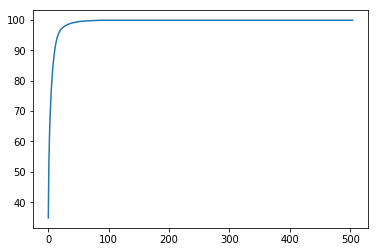

In [75]:
# test run_preproc for training
#run_preproc_w_scale_cat_lut_w_platform( no_noise_nc, with_noise_nc_array, var1, numPC1, 
#                                outputPath, ro_val, mode, platform, var2=str(), numPC2 = 0)

run_preproc_w_scale_cat_lut_reduced_w_platform( '..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc',
                                       nc_array, "ref_i", 5, 
                                       '..//..//py_data//oracles_NN//input2NN//', 
                                       '000', mode='predict', platform='P3', var2="dolp", numPC2 = 55)

['..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_10.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_11.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_12.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_13.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_14.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_15.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_20.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_21.0000_0.90_cut.nc', '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_22.0000_0.90_cut.nc', '..//..//py_data//oracles_N

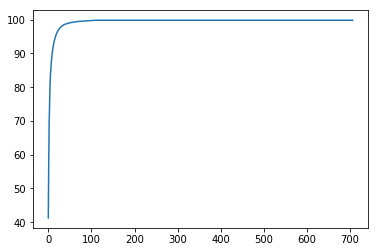

In [25]:
# test run_preproc for training
# concatanate several noise realizations 
# *sampled* is for all Azi/SZA realizations
# *PP* is for Azi about 0-15
nc_array = ['..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_10.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_11.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_12.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_13.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_14.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_15.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_20.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_21.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_22.0000_0.90_cut.nc',
            '..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_23.0000_0.90_cut.nc']

#nc_array = ['..//..//py_data//oracles_NN//simulated_files//rho090_cut//NN_clouds_20170505_sampled_10.0000_0.90_cut.nc']
print nc_array
run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_sampled_cut.nc',
                            nc_array, 
                            "ref_q", 30, '..//..//py_data//oracles_NN//input2NN//',
                            '090', mode='train',platform='ER2', var2="dolp",numPC2=30)

concat file#1:, ..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc
final concat file size
(261144, 707)
concat df
        ref_q_lambda_1_VZA_  ref_q_lambda_1_VZA_  ref_q_lambda_1_VZA_  \
261139            -0.064258            -0.063230            -0.062295   
261140            -0.065726            -0.064544            -0.063382   
261141            -0.067139            -0.066056            -0.065012   
261142            -0.067772            -0.066591            -0.065466   
261143            -0.068527            -0.067456            -0.066405   

        ref_q_lambda_1_VZA_  ref_q_lambda_1_VZA_  ref_q_lambda_1_VZA_  \
261139            -0.061419            -0.060600            -0.059779   
261140            -0.062299            -0.061272            -0.060284   
261141            -0.063901            -0.062770            -0.061717   
261142            -0.064509            -0.063661            -0.062769   
261143            -0.065270            -0.

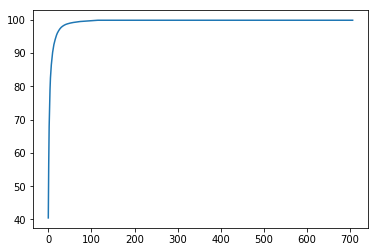

In [22]:
# test run_preproc for training
#run_preproc_w_scale_cat_lut_w_platform( no_noise_nc, with_noise_nc_array, var1, numPC1, 
#                                outputPath, ro_val, mode, platform, var2=str(), numPC2 = 0)

run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc',
                                       nc_array, "ref_q", 30, 
                                       '..//..//py_data//oracles_NN//input2NN//', 
                                       '000', mode='train', platform='P3', var2="dolp", numPC2 = 30)


In [ ]:
# list all files in folder to process for prediction
import glob
import os

data_dir = "C://Users//msegalro.NDC//Documents//R//oracles_polar_algorithm//data//ORACLES2017//RSP//"
#data_dir = "..//..//py_data//oracles_NN//"
#subdir   = 'NN_ready//with_swir'
subdir   = 'NN_ready'
path     = os.path.join(data_dir,subdir + "//")
print path
fname = []
for file in os.listdir(path):
    print file
    if file.endswith(".nc"):
        fname = os.path.join(data_dir,subdir + "//",file)
        print fname
        #run_preproc_w_scale_cat_lut( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
        #     [fname], "ref_i", 5, 
        #    '..//..//py_data//oracles_NN//input2NN//',
        #    '090', mode='predict',var2="dolp",numPC2=55)
        # this aparently was used to project 2017 field data? mmm...
        #run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
        #     [fname], "ref_i", 5, 
        #    '..//..//py_data//oracles_NN//input2NN//',
        #    '000', mode='predict',platform='P3', var2="dolp",numPC2=55)
        # this is for reduced dataset;no swir channels
        run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//P3//no_noise//NN_clouds_20170627-20170703.nc',
             [fname], "ref_q", 30, 
            '..//..//py_data//oracles_NN//input2NN//',
            '000', mode='predict',platform='P3', var2="dolp",numPC2=30)

C://Users//msegalro.NDC//Documents//R//oracles_polar_algorithm//data//ORACLES2016//RSP//NN_ready//
dolp_calc_from_q_u
not_rotated
old
RSP1
RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T082047Z_V002-20170316T193311Z_NN.nc
C://Users//msegalro.NDC//Documents//R//oracles_polar_algorithm//data//ORACLES2016//RSP//NN_ready//RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T082047Z_V002-20170316T193311Z_NN.nc
concat file#1:, C://Users//msegalro.NDC//Documents//R//oracles_polar_algorithm//data//ORACLES2016//RSP//NN_ready//RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T082047Z_V002-20170316T193311Z_NN.nc
final concat file size
(2135, 707)
concat df
      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
2130             0.317360             0.312912             0.310348   
2131             0.318086             0.313382             0.311351   
2132             0.312468             0.319056             0.322369   
2133             0.352514             0.320080             0.350660   
2134             0.340133     

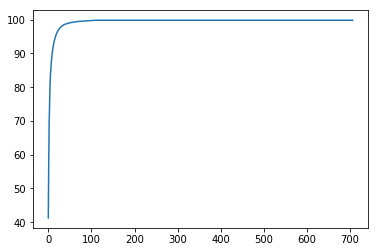

In [ ]:
# list all files in folder to process for prediction - this is ORACLES 2016 ER-2
import glob
import os

data_dir = "C://Users//msegalro.NDC//Documents//R//oracles_polar_algorithm//data//ORACLES2016//RSP//"
#data_dir = "..//..//py_data//oracles_NN//"
#subdir   = 'NN_ready//with_swir'
subdir   = 'NN_ready'
path     = os.path.join(data_dir,subdir + "//")
print path
fname = []
for file in os.listdir(path):
    print file
    if file.endswith(".nc"):
        fname = os.path.join(data_dir,subdir + "//",file)
        print fname
        #run_preproc_w_scale_cat_lut( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
        #     [fname], "ref_i", 5, 
        #    '..//..//py_data//oracles_NN//input2NN//',
        #    '090', mode='predict',var2="dolp",numPC2=55)
        # this aparently was used to project 2017 field data? mmm...
        #run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
        #     [fname], "ref_i", 5, 
        #    '..//..//py_data//oracles_NN//input2NN//',
        #    '000', mode='predict',platform='P3', var2="dolp",numPC2=55)
        # this is for reduced dataset;no swir channels
        run_preproc_w_scale_cat_lut_w_platform( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_sampled_cut.nc',
             [fname], "ref_i", 5, 
            '..//..//py_data//oracles_NN//input2NN//',
            '090', mode='predict',platform='ER2', var2="dolp",numPC2=55)


concat file#1:, C://Users//msegalro.NDC//WinPython-64bit-2.7.9.5//notebooks//py_data//oracles_NN//measurements\RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN.nc
final concat file size
(1219, 707)
concat df
      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
1214             0.220082             0.221533             0.217358   
1215             0.215038             0.213618             0.213102   
1216             0.214080             0.212928             0.211981   
1217             0.214080             0.212928             0.211530   
1218             0.282644             0.296338             0.317423   

      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
1214             0.213944             0.213882             0.215759   
1215             0.211461             0.210637             0.209405   
1216             0.210851             0.209606             0.208439   
1217             0.210708             0.208872             0

IOError: [Errno 2] No such file or directory: 'C://Users//msegalro.NDC//WinPython-64bit-2.7.9.5//notebooks//py_data//oracles_NN//input2NN//measurements\\RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN_ref_i_dolp_090.csv'

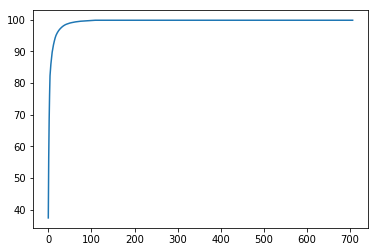

In [40]:
fl = flist[0]
run_preproc_w_scale_cat_lut( 'C://Users//msegalro.NDC//WinPython-64bit-2.7.9.5//notebooks//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
             [fl], 
             "ref_i", 5, 'C://Users//msegalro.NDC//WinPython-64bit-2.7.9.5//notebooks//py_data//oracles_NN//input2NN//','090', mode='predict',var2="dolp",numPC2=55)

..//..//py_data//oracles_NN/measurements\RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN.nc
concat file#1:, ..//..//py_data//oracles_NN/measurements\RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN.nc
final concat file size
(1219, 707)
concat df
      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
1214             0.220082             0.221533             0.217358   
1215             0.215038             0.213618             0.213102   
1216             0.214080             0.212928             0.211981   
1217             0.214080             0.212928             0.211530   
1218             0.282644             0.296338             0.317423   

      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
1214             0.213944             0.213882             0.215759   
1215             0.211461             0.210637             0.209405   
1216             0.210851             0.209606             0.208439   


IOError: [Errno 2] No such file or directory: '..//..//py_data//oracles_NN//input2NN//oracles_NN/measurements\\RSP2-ER2_L2-RSPCLOUD-Clouds_20160910T073350Z_V002-20170316T192510Z_NN_ref_i_dolp_090.csv'

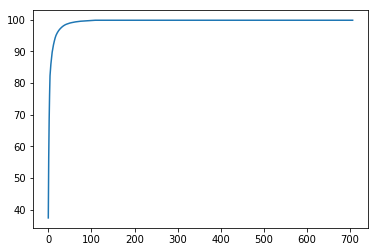

In [23]:
# process all files in flist for prediction:
for f in range(len(flist)):
        print flist[f]
        run_preproc_w_scale_cat_lut( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
             [flist[f]], 
             "ref_i", 5, '..//..//py_data//oracles_NN//input2NN//','090', mode='predict',var2="dolp",numPC2=55)

concat file#1:, ..//..//py_data//oracles_NN/measurements//RSP2-ER2_L1B-RSPGEOL1B-GeolocatedRadiances_20160927T102159Z_V001-20160927T211209Z_NN.nc
final concat file size
(2472, 707)
concat df
      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
2467             0.451507             0.452313             0.453878   
2468             0.454184             0.454745             0.455694   
2469             0.455573             0.456008             0.456666   
2470             0.456200             0.457293             0.457868   
2471             0.456776             0.457519             0.457868   

      ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
2467             0.454639             0.453963             0.453631   
2468             0.455999             0.455510             0.455050   
2469             0.456470             0.455899             0.455818   
2470             0.457606             0.457016             0.456446   
2471             0.457862  

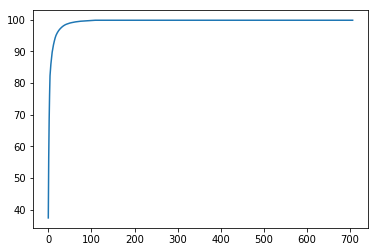

In [29]:
# test run_preproc for prediction
run_preproc_w_scale_cat_lut( '..//..//py_data//oracles_NN//simulated_files//NN_clouds_20170505_PP_cut_good.nc',
             ['..//..//py_data//oracles_NN/measurements//RSP2-ER2_L1B-RSPGEOL1B-GeolocatedRadiances_20160927T102159Z_V001-20160927T211209Z_NN.nc'], 
             "ref_i", 5, '..//..//py_data//oracles_NN//input2NN//','090', mode='predict',var2="dolp",numPC2=55)